In [14]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

pd.options.display.max_rows = 150

In [2]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [3]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

In [4]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [5]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

In [6]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    feature_chart = feature_importance(model)
    
    return output

# Baseline

In [7]:
adaboost = AdaBoostClassifier(random_state=42)
model = adaboost.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,1655,9,0.934037,0.920354,0.0648,0.059125,0.955038,0.948537


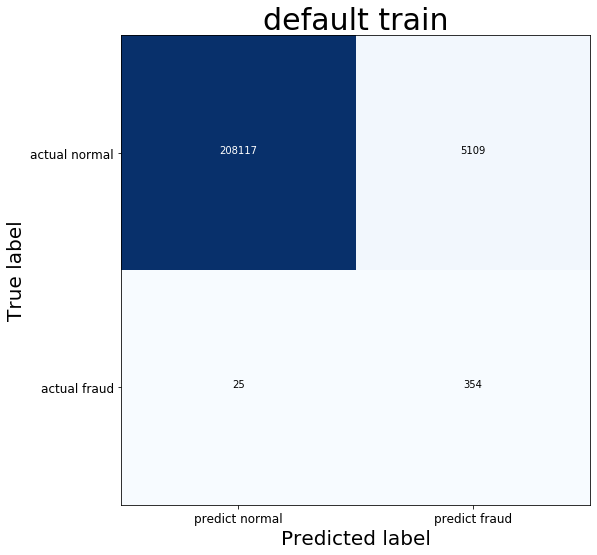

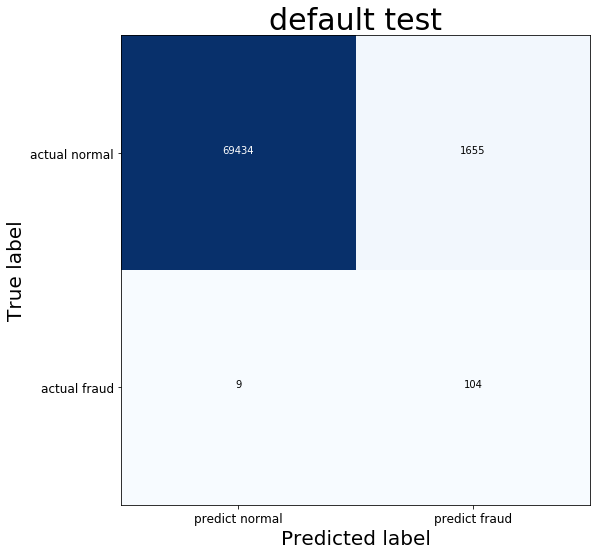

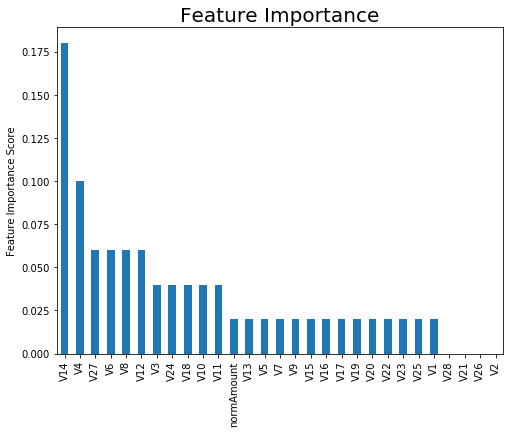

In [8]:
model_vis(model,'default')

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default stratify,1540,5,0.912929,0.955752,0.069283,0.065534,0.945565,0.967045


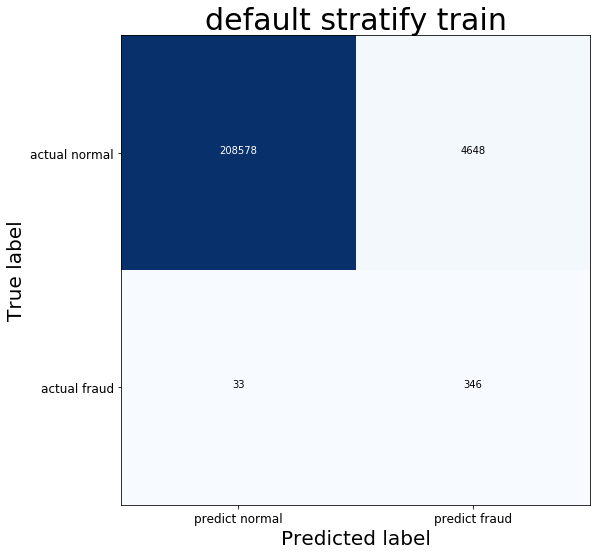

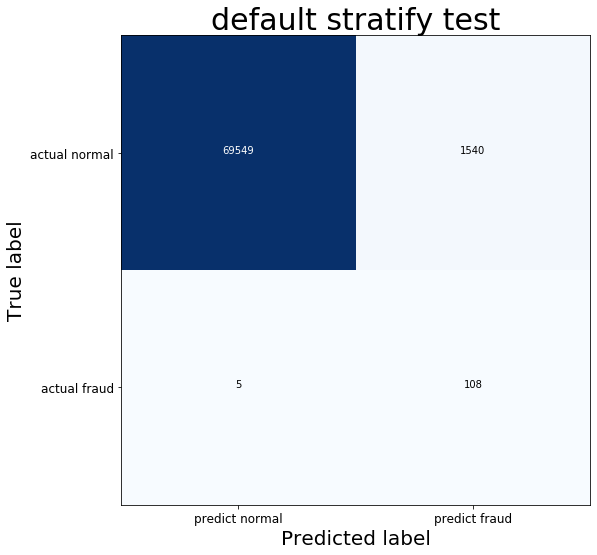

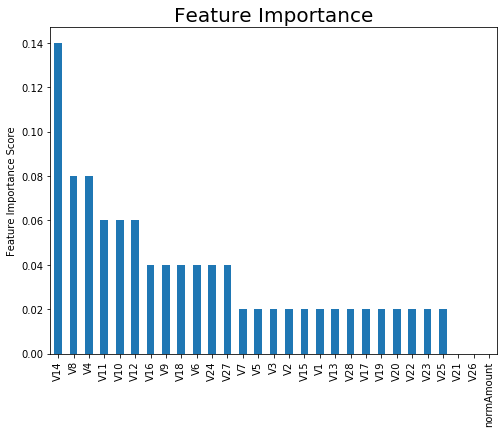

In [9]:
model = adaboost.fit(X_train_sm_sf, y_train_sm_sf.ravel())
model_vis(model,'default stratify')

# Params tuning

In [ ]:
AdaBoostClassifier()

In [ ]:
# https://scikit-learn.org/stable/modules/ensemble.html#adaboost

In [10]:
# learning rate, n_estimator
# base_estimator

### Step 1: n_estimators, learning_rate

In [11]:
param_grid = {
    'n_estimators': [50,100,200,500],
    'learning_rate': [1,0.5,0.25,0.1]
}

gs1 = GridSearchCV(AdaBoostClassifier(random_state=42),
                   param_grid=param_grid,
                   cv=5,
                   verbose=3,
                   n_jobs=4)
gs1.fit(X_train_sm_sf, y_train_sm_sf.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 40.0min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 172.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=4,
             param_grid={'learning_rate': [1, 0.5, 0.25, 0.1],
                         'n_estimators': [50, 100, 200, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [12]:
gs1.best_params_,gs1.best_score_

({'learning_rate': 1, 'n_estimators': 500}, 0.9914460978809029)

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 1,558,8,0.941953,0.929204,0.192765,0.158371,0.967471,0.960677


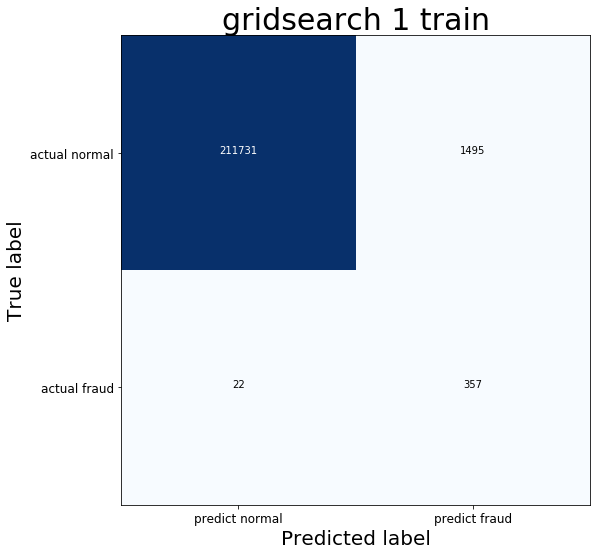

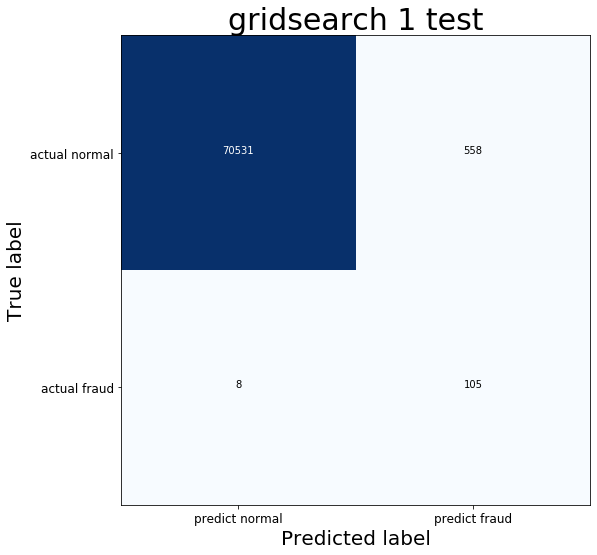

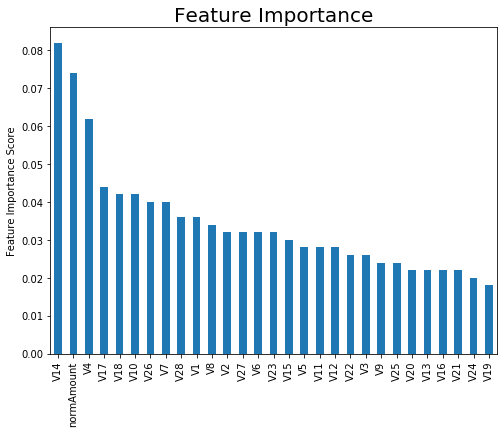

In [13]:
ada_grid = AdaBoostClassifier(learning_rate=1,n_estimators=500, random_state=42)
model = ada_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())
model_vis(model,'gridsearch 1')

## step 2: base estimator

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch extra trees,6,7,0.960422,0.938053,0.981132,0.946429,0.980195,0.968984


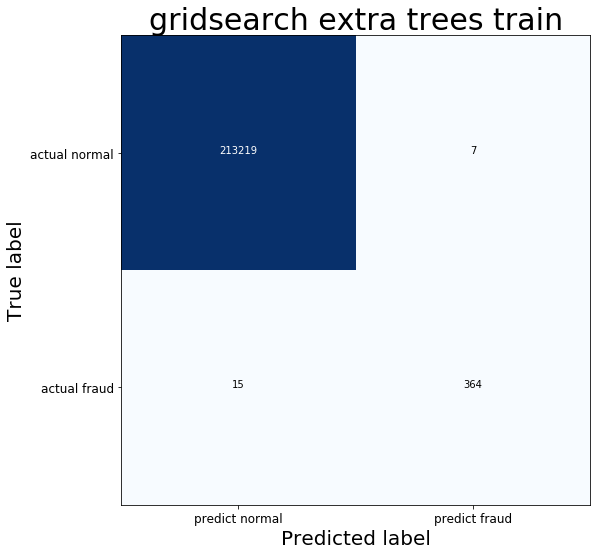

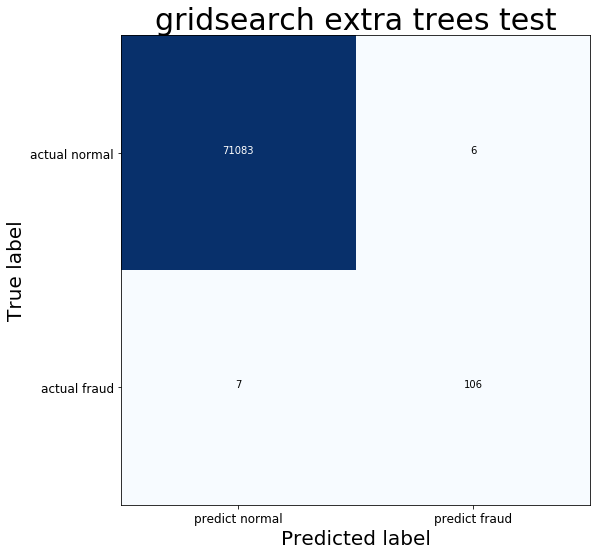

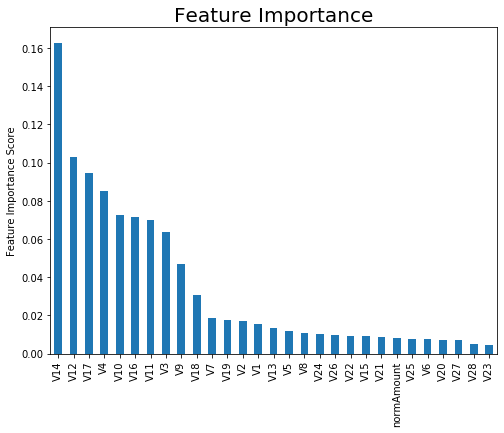

In [19]:
ada_grid = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=42),
                              learning_rate=1,
                              n_estimators=500, 
                              random_state=42)
model = ada_grid.fit(X_train_sm_sf,y_train_sm_sf.ravel())
model_vis(model,'gridsearch extra trees')